In [1]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from optimization import run_optimization
from optimization_class import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 150
nx, ny = int(Nx/2), int(Ny/2)
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [10, 10]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [13]:
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
# d = int(d/2/dl)*dl*2
eps_m = 5

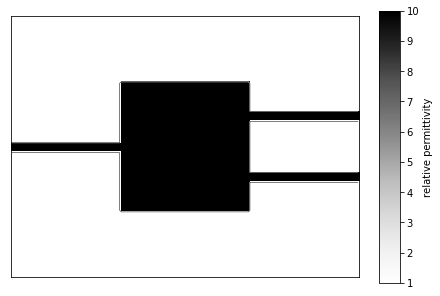

In [14]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, shape, eps_start=10)
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()

In [15]:
eps = simulation.eps_r
pts_in = np.sum(eps[15,:] > 1)
pts_top = np.sum(eps[Nx-15,:ny] > 1)
pts_bot = np.sum(eps[Nx-15,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))


waveguide has 5 points in in port
waveguide has 5 points in top port
waveguide has 5 points in bottom port


In [6]:
# set the modal source and probes

# simulation to solve
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [15, ny], int(d/dl), scale=70)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Fdfd(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-15, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Fdfd(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-15, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 7.136073883668608 W/L0


In [7]:
# set source and solve for electromagnetic fields
print('{} grids per wavelength'.format(int(lambda0/dl/1e-6)))
(Hx,Hy,Ez) = simulation.solve_fields()

50 grids per wavelength


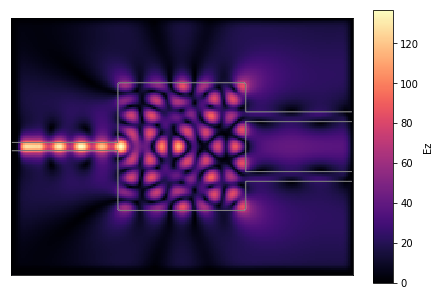

In [8]:
# plot linear field
simulation.plt_abs(outline=True, cbar=True);

In [9]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[Nx-15, ny+int(d/2/dl)] = 1
Jregion_nl = np.zeros(eps_r.shape)
Jregion_nl[Nx-15, ny-int(d/2/dl)] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

## Purely Linear

## Both Linear and Nonlinear

In [10]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e*J_top)))
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e*J_bot)))
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e: np.conj(e)*J_bot
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['deps_de'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

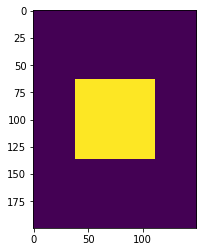

In [11]:
plt.imshow(design_region)

In [12]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=1200, J=J, dJdE=dJdE, eps_max=5, step_size=.1, solver='newton', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

  5% (66 of 1200) |#                     | Elapsed Time: 0:03:30 ETA:   0:57:25ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-eb36f01e7774>", line 7, in <module>
    (new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)
  File "/Users/twh/Documents/Fan/Code/nonlinear_avm/optimization_class.py", line 84, in run
    max_num_iter=50)
  File "/Users/twh/Documents/Fan/Code/fdfdpy/fdfdpy/Fdfd.py", line 150, in solve_fields_nl
    (Hx, Hy, Ez, conv_array) = newton_solve(self, nonlinear_fn, nl_region, dnl_de, Estart, conv_threshold, max_num_iter, averaging=averaging)
  File "/Users/twh/Documents/Fan/Code/fdfdpy/fdfdpy/nonlinear_solvers.py", line 119, in newton_solve
    Ediff = solver_complex2real(Jac11, Jac12, fx, solver=solver, timing=False)
  File "/Users/twh/Documents/Fan/Code/fdfdpy/fdfdpy/linalg.py", line 175, in solver_complex2real
    pSolve.factor()
  File "/Us

KeyboardInterrupt: 

In [ ]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

In [ ]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()

In [ ]:
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

In [ ]:
# save this nice permittivity to a file
np.save('../data/eps_good', new_eps)

In [ ]:
eps_saved = np.load('../data/eps_good.npy')
simulation.reset_eps(eps_saved)

W_in = simulation.W_in

(Hx,Hy,Ez) = simulation.solve_fields()
W_top_lin = simulation.flux_probe('x', [Nx-15, ny+int(d/2/dl)], int(d/dl))
W_bot_lin = simulation.flux_probe('x', [Nx-15, ny-int(d/2/dl)], int(d/dl))

(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
W_top_nl = simulation.flux_probe('x', [Nx-15, ny+int(d/2/dl)], int(d/dl))
W_bot_nl = simulation.flux_probe('x', [Nx-15, ny-int(d/2/dl)], int(d/dl))

simulation.plt_abs()
plt.show()

In [ ]:
S = np.array([[W_top_lin, W_bot_lin],[W_top_nl, W_bot_nl]])/W_in
plt.imshow(S, cmap='magma')
plt.colorbar()
plt.xlabel('top vs. bottom')
plt.ylabel('linear vs. nonlinear')
plt.title('normalized power')
plt.show()

# Adam Optimization

You can now include `opt_method = 'adam'` (default) or `opt_method = 'descent'` when you create an optimization object and define whether to use Adam or vanilla gradient descent. 
 
Note: Adam is scale-invariant in the sense that the step size is independent of the normalization of the objective function. In the example above using gradient descent, the step size needed to be very small because the objective function (and hence the gradient) is very large. With Adam, regardless of the objective function, the update to all parameters is of the order of the step_size. Since eps_r is between 1 and 5, a step size of 0.1-0.01 should be fine. 

Note: In the example below, even step_size = 0.1 works very well in the beginning. However, in the end, when the simulation starts diverging occasionally, a smaller step size helps, hence I used 0.04.

Note: The simulation starts diverging only for values of the objective function that are *above* the values reached during the gradient descent above. The divergence is thus *not* because of Adam. 

In [ ]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=1400, J=J, dJdE=dJdE, eps_max=5, step_size=.01, solver='newton', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

In [ ]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()

In [ ]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()

Lastly I wanted to check the same thing using the Born solver. It's much worse.

In [ ]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=400, J=J, dJdE=dJdE, eps_max=5, step_size=.04, solver='born', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps, obj_fns) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

In [ ]:
simulation.plt_eps()
plt.show()
plt.plot(obj_fns)
plt.show()
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['deps_de'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()